In [5]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [41]:
%load_ext autoreload
%autoreload 2
from dataset import *
from dynamic_tracker import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
scene_id = 690
N = 800

dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=scene_id, N=N)

scene_id=690 scene_name=scene-0904 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:313: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 ...
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]]


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

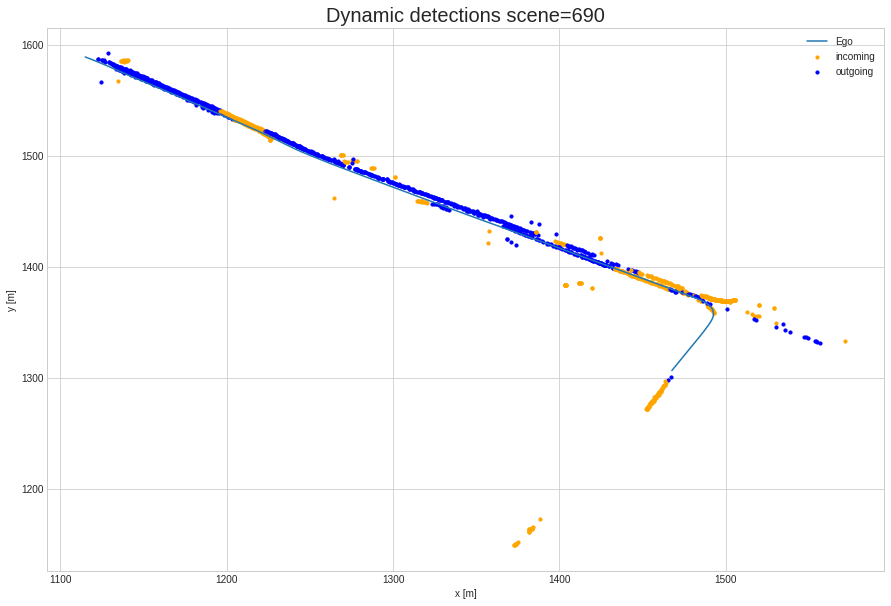

In [26]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
colors = ['blue','orange','green','red','black','pink','yellow','purple',"brown","firebrick","coral","lime",
                      "wheat", "yellowgreen", "lightyellow", "skyblue", "cyan", "chocolate", "maroon", "peru", "blueviolet"]

start_frame = 0
n_frames = 800
ego_path = dataset.getEgoPath()
ax.plot(ego_path[start_frame:n_frames,0], ego_path[start_frame:n_frames,1])
model = ClassicDBSCAN(eps=3, min_samples=2)
for t in range(start_frame,n_frames):
    pc, ts, heading, speed = dataset.getDynamicPoints(t)
    if pc.shape[0] < 1:
        continue
    
    Z, X = model.run(pc=pc, ego=ego_path[t], heading=heading)
    for z,x in zip(Z,X):
        vr = z[2]
        x_com = x[0]
        y_com = x[1]
        v_towards = 0 if vr > 0 else 1
        ax.scatter(x_com, y_com, s=10, c=colors[v_towards])
        
ax.set_title(f"Dynamic detections scene={scene_id}", fontsize=20)
ax.set(xlabel='x [m]', ylabel='y [m]')
ax.legend(['Ego', 'incoming','outgoing'])
leg = ax.get_legend()
#leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('orange')
leg.legendHandles[2].set_color('blue')

In [42]:
start_frame=0
n_frames = 100
ego_path = dataset.getEgoPath()[:n_frames]
tracker = DynamicTracker()
dbscan_clustering = ClassicDBSCAN()
for t in range(start_frame,n_frames):
    pc, ts, heading, ego_speed = dataset.getDynamicPoints(t)
    Z, _ = dbscan_clustering.run(pc=pc, ego=ego_path[t], heading=np.deg2rad(heading))
    tracker.run(Z, ts, {"heading": np.deg2rad(heading), "T": ego_path[t]}, ego_speed)

/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 1
Number of new plots 2
Number of dynamic tracks before run() 0
Initiating new track: x=[[7.62498588]
 [2.67594329]
 [1.17947535]
 [0.41392983]] for measurement z=[8.0809085  0.33751558 1.25      ]
Initiating new track: x=[[7.62498588]
 [2.67594329]
 [1.17947535]
 [0.41392983]] for measurement z=[8.0809085  0.33751558 1.25      ]
trk.kf.x = [[7.62498588]
 [2.67594329]
 [1.17947535]
 [0.41392983]] age = 1 hits = 1
trk.kf.x = [[7.62498588]
 [2.67594329]
 [1.17947535]
 [0.41392983]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 2
Number of new plots 1
Number of dynamic tracks before run() 2
Initiating new track: x=[[19.62331081]
 [ 2.27141077]
 [ 1.98673494]
 [ 0.22996584]] for measurement z=[19.75433203  0.11523781  2.        ]
trk.kf.x = [[7.70915563]
 [2.70883855]
 [1.12796487]
 [0.41419036]] age = 2 hits = 1
trk.kf.x = [[7.70915563]
 [2.70883855]
 [1.12796487]
 [0.41419036]] age = 2 hits = 1
trk.kf.x = [[19.62331081]
 [ 2.27141077]
 [ 1.98673494]
 [ 0.22996584]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 3
Number of new plots 2
Number of dynamic tracks before run() 3
Initiating new track: x=[[ 18.94481003]
 [-14.97494601]
 [  2.15740166]
 [ -1.70532052]] for measurement z=[24.14859903 -0.66889126  2.75      ]
trk.kf.x = [[7.78656976]
 [2.74517914]
 [1.05719567]
 [0.41490854]] age = 3 hits = 1
trk.kf.x = [[7.78656976]
 [2.74517914]
 [1.05719567]
 [0.41490854]] age = 3 hits = 1
trk.kf.x = [[19.84215193]
 [ 2.32961479]
 [ 2.01175804]
 [ 0.24276665]] age = 2 hits = 2
trk.kf.x = [[ 18.94481003]
 [-14.97494601]
 [  2.15740166]
 [ -1.70532052]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 4
Number of new plots 2
Number of dynamic tracks before run() 4
Initiating new track: x=[[9.85689625]
 [9.66514604]
 [1.249531  ]
 [1.22522336]] for measurement z=[13.80483436  0.77557624  1.75      ]
Initiating new track: x=[[20.5489798 ]
 [ 0.58371769]
 [ 2.99879037]
 [ 0.08518413]] for measurement z=[20.55726872  0.02839853  3.        ]
trk.kf.x = [[7.8591533 ]
 [2.7803292 ]
 [0.98732537]
 [0.41541768]] age = 4 hits = 1
trk.kf.x = [[7.8591533 ]
 [2.7803292 ]
 [0.98732537]
 [0.41541768]] age = 4 hits = 1
trk.kf.x = [[19.98649924]
 [ 2.3581158 ]
 [ 1.94197637]
 [ 0.243768  ]] age = 3 hits = 2
trk.kf.x = [[ 19.10907122]
 [-15.09290886]
 [  2.08862443]
 [ -1.70424382]] age = 2 hits = 1
trk.kf.x = [[9.85689625]
 [9.66514604]
 [1.249531  ]
 [1.22522336]] age = 1 hits = 1
trk.kf.x = [[20.5489798 ]
 [ 0.58371769]
 [ 2.99879037]
 [ 0.08518413]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 5
Number of new plots 1
Number of dynamic tracks before run() 6
trk.kf.x = [[7.92727678]
 [2.81427615]
 [0.92071462]
 [0.41573958]] age = 5 hits = 1
trk.kf.x = [[7.92727678]
 [2.81427615]
 [0.92071462]
 [0.41573958]] age = 5 hits = 1
trk.kf.x = [[20.12641682]
 [ 2.38344587]
 [ 1.87542557]
 [ 0.24442365]] age = 4 hits = 2
trk.kf.x = [[ 19.26614611]
 [-15.21407111]
 [  2.02275464]
 [ -1.70353678]] age = 3 hits = 1
trk.kf.x = [[9.94226894]
 [9.76057052]
 [1.18263713]
 [1.22563688]] age = 2 hits = 1
trk.kf.x = [[20.62226037]
 [ 0.45201561]
 [ 3.0399716 ]
 [ 0.08659511]] age = 2 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 6
Number of new plots 2
Number of dynamic tracks before run() 6
Initiating new track: x=[[11.223006  ]
 [ 2.25923638]
 [ 1.47050109]
 [ 0.2960178 ]] for measurement z=[11.44814451  0.19864912  1.5       ]
trk.kf.x = [[7.99262538]
 [2.84556015]
 [0.87228979]
 [0.41575251]] age = 6 hits = 1
trk.kf.x = [[7.99262538]
 [2.84556015]
 [0.87228979]
 [0.41575251]] age = 6 hits = 1
trk.kf.x = [[20.26334095]
 [ 2.40206927]
 [ 1.82700328]
 [ 0.24445074]] age = 5 hits = 2
trk.kf.x = [[ 19.41437769]
 [-15.3414872 ]
 [  1.97436123]
 [ -1.70350751]] age = 4 hits = 1
trk.kf.x = [[10.02714842]
 [ 9.85259783]
 [ 1.13420029]
 [ 1.2256537 ]] age = 3 hits = 1
trk.kf.x = [[21.12165739]
 [ 0.3932662 ]
 [ 2.9984036 ]
 [ 0.08326863]] age = 3 hits = 3
trk.kf.x = [[11.223006  ]
 [ 2.25923638]
 [ 1.47050109]
 [ 0.2960178 ]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 7
Number of new plots 2
Number of dynamic tracks before run() 7
trk.kf.x = [[8.40614934]
 [2.6196606 ]
 [1.25256972]
 [0.54044084]] age = 7 hits = 2
trk.kf.x = [[8.10588373]
 [2.90358629]
 [0.74461018]
 [0.41535221]] age = 7 hits = 1
trk.kf.x = [[20.51960094]
 [ 2.42771675]
 [ 1.69923143]
 [ 0.24353714]] age = 6 hits = 2
trk.kf.x = [[ 19.68305152]
 [-15.60768562]
 [  1.84554198]
 [ -1.70450006]] age = 5 hits = 1
trk.kf.x = [[10.18353927]
 [10.03103437]
 [ 1.00695611]
 [ 1.22511246]] age = 4 hits = 1
trk.kf.x = [[21.82683174]
 [ 0.53873388]
 [ 2.69750682]
 [ 0.09942293]] age = 4 hits = 4
trk.kf.x = [[11.42570115]
 [ 2.29751113]
 [ 1.34275701]
 [ 0.29529587]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 8
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[8.47815274]
 [2.6668578 ]
 [1.28289809]
 [0.56167799]] age = 8 hits = 3
trk.kf.x = [[20.6431365 ]
 [ 2.43934822]
 [ 1.63593144]
 [ 0.24301071]] age = 7 hits = 2
trk.kf.x = [[ 19.811715  ]
 [-15.74196241]
 [  1.78161511]
 [ -1.70507348]] age = 6 hits = 1
trk.kf.x = [[10.25759956]
 [10.11966277]
 [ 0.94397203]
 [ 1.22480875]] age = 5 hits = 1
trk.kf.x = [[21.93757667]
 [ 0.50262187]
 [ 2.67429967]
 [ 0.0939581 ]] age = 5 hits = 5
trk.kf.x = [[11.52244777]
 [ 2.31596144]
 [ 1.2794737 ]
 [ 0.29488415]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 9
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[8.71621583]
 [2.92245989]
 [1.2754758 ]
 [0.63431617]] age = 9 hits = 4
trk.kf.x = [[20.76377937]
 [ 2.44512733]
 [ 1.58869244]
 [ 0.24205802]] age = 8 hits = 2
trk.kf.x = [[ 19.93229627]
 [-15.88183323]
 [  1.73320782]
 [ -1.70611318]] age = 7 hits = 1
trk.kf.x = [[10.33098354]
 [10.20535429]
 [ 0.89732193]
 [ 1.22427085]] age = 6 hits = 1
trk.kf.x = [[22.07194295]
 [ 0.48442364]
 [ 2.66486559]
 [ 0.09089749]] age = 6 hits = 6
trk.kf.x = [[11.61627916]
 [ 2.33111782]
 [ 1.23226587]
 [ 0.29414522]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 10
Number of new plots 1
Number of dynamic tracks before run() 4
trk.kf.x = [[8.80882818]
 [2.96448221]
 [1.20989746]
 [0.6335519 ]] age = 10 hits = 4
trk.kf.x = [[10.3998553 ]
 [10.29063187]
 [ 0.8321164 ]
 [ 1.22374537]] age = 7 hits = 1
trk.kf.x = [[22.42106783]
 [ 0.41393571]
 [ 2.73298506]
 [ 0.07183341]] age = 7 hits = 7
trk.kf.x = [[11.70525955]
 [ 2.34579012]
 [ 1.16647263]
 [ 0.29340832]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 11
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[8.93640132]
 [2.94138513]
 [1.24121837]
 [0.60693345]] age = 11 hits = 5
trk.kf.x = [[22.5827029 ]
 [ 0.41463739]
 [ 2.6900218 ]
 [ 0.06480234]] age = 8 hits = 8
trk.kf.x = [[11.78559613]
 [ 2.37901923]
 [ 1.1006058 ]
 [ 0.29445575]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 12
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[9.09246471]
 [3.07349389]
 [1.12904579]
 [0.61203131]] age = 12 hits = 5
trk.kf.x = [[22.91321102]
 [ 0.59715468]
 [ 2.53822921]
 [ 0.11100764]] age = 9 hits = 9
trk.kf.x = [[11.92327868]
 [ 2.47699915]
 [ 0.98984383]
 [ 0.29892267]] age = 7 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 13
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[9.16278021]
 [3.15001029]
 [1.06557115]
 [0.6155531 ]] age = 13 hits = 5
trk.kf.x = [[23.0827166 ]
 [ 0.64438055]
 [ 2.57257677]
 [ 0.10044903]] age = 10 hits = 10


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 14
Number of new plots 1
Number of dynamic tracks before run() 2
Initiating new track: x=[[23.20891422]
 [-0.79607765]
 [ 3.4979429 ]
 [-0.11998123]] for measurement z=[23.22256314 -0.03428707  3.5       ]
trk.kf.x = [[9.23602358]
 [3.21755017]
 [1.00157432]
 [0.61757217]] age = 14 hits = 5
trk.kf.x = [[23.28084325]
 [ 0.69926867]
 [ 2.50961464]
 [ 0.10550523]] age = 11 hits = 10
trk.kf.x = [[23.20891422]
 [-0.79607765]
 [ 3.4979429 ]
 [-0.11998123]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 15
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[9.30118524]
 [3.27891576]
 [0.93479869]
 [0.61907042]] age = 15 hits = 5
trk.kf.x = [[23.45067252]
 [ 0.75450604]
 [ 2.5560541 ]
 [ 0.11687246]] age = 12 hits = 11
trk.kf.x = [[23.46838533]
 [-0.76751114]
 [ 3.43234555]
 [-0.1144831 ]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 16
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[9.61613976]
 [3.34386406]
 [1.3094978 ]
 [0.69633095]] age = 16 hits = 6
trk.kf.x = [[23.61770262]
 [ 0.77217993]
 [ 2.59413334]
 [ 0.10898379]] age = 13 hits = 12
trk.kf.x = [[23.72123418]
 [-0.74980334]
 [ 3.36816884]
 [-0.11075252]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 17
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[9.80402321]
 [3.35035432]
 [1.42571616]
 [0.65787039]] age = 17 hits = 7
trk.kf.x = [[23.7973896 ]
 [ 0.80679749]
 [ 2.64630906]
 [ 0.10662273]] age = 14 hits = 13
trk.kf.x = [[23.97145114]
 [-0.72172023]
 [ 3.32145826]
 [-0.10571044]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 18
Number of new plots 3
Number of dynamic tracks before run() 3
Initiating new track: x=[[15.04786772]
 [ 7.8403567 ]
 [-1.3486145 ]
 [-0.70266558]] for measurement z=[16.96789663  0.48032795 -1.52069063]
trk.kf.x = [[10.082945  ]
 [ 3.39476308]
 [ 1.47821141]
 [ 0.60966921]] age = 18 hits = 8
trk.kf.x = [[24.17828245]
 [ 0.8738088 ]
 [ 2.67623413]
 [ 0.11036273]] age = 15 hits = 14
trk.kf.x = [[24.45291768]
 [-0.6796925 ]
 [ 3.19759724]
 [-0.0981404 ]] age = 5 hits = 1
trk.kf.x = [[15.04786772]
 [ 7.8403567 ]
 [-1.3486145 ]
 [-0.70266558]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 19
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[10.24323347]
 [ 3.38779888]
 [ 1.52363707]
 [ 0.55701236]] age = 19 hits = 9
trk.kf.x = [[24.37416848]
 [ 0.91637205]
 [ 2.70718529]
 [ 0.11505226]] age = 16 hits = 15
trk.kf.x = [[24.68931319]
 [-0.6523321 ]
 [ 3.13800991]
 [-0.09372693]] age = 6 hits = 1
trk.kf.x = [[14.90688547]
 [ 7.90986916]
 [-1.3742567 ]
 [-0.68515151]] age = 2 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 20
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[10.41062885]
 [ 3.34206313]
 [ 1.5708478 ]
 [ 0.46695985]] age = 20 hits = 10
trk.kf.x = [[24.58186543]
 [ 0.94245182]
 [ 2.76907769]
 [ 0.11258487]] age = 17 hits = 16
trk.kf.x = [[24.92175241]
 [-0.6326667 ]
 [ 3.09076283]
 [-0.09041647]] age = 7 hits = 1
trk.kf.x = [[14.96824378]
 [ 7.89088046]
 [-1.28575671]
 [-0.616436  ]] age = 3 hits = 3


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 21
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[10.58820224]
 [ 3.30413186]
 [ 1.60005284]
 [ 0.38401741]] age = 21 hits = 11
trk.kf.x = [[24.80674264]
 [ 0.95274784]
 [ 2.80241363]
 [ 0.09545943]] age = 18 hits = 17
trk.kf.x = [[15.14861389]
 [ 7.98689979]
 [-1.18037422]
 [-0.53574944]] age = 4 hits = 4


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 22
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[10.80713957]
 [ 3.19382577]
 [ 1.65708915]
 [ 0.21859877]] age = 22 hits = 12
trk.kf.x = [[25.00943304]
 [ 0.98581079]
 [ 2.82205726]
 [ 0.08048205]] age = 19 hits = 18
trk.kf.x = [[14.88534707]
 [ 8.13816825]
 [-1.29885055]
 [-0.53228148]] age = 5 hits = 5


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 23
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[10.91574583]
 [ 3.14972871]
 [ 1.67199867]
 [ 0.14812303]] age = 23 hits = 13
trk.kf.x = [[25.21619657]
 [ 0.99960761]
 [ 2.84025408]
 [ 0.04296195]] age = 20 hits = 19
trk.kf.x = [[14.79159852]
 [ 8.23198857]
 [-1.27029802]
 [-0.46626891]] age = 6 hits = 6


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 24
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[11.14618808]
 [ 3.11743185]
 [ 1.6866939 ]
 [ 0.08818204]] age = 24 hits = 14
trk.kf.x = [[25.68748674]
 [ 1.08931072]
 [ 2.93074544]
 [ 0.06344346]] age = 21 hits = 20
trk.kf.x = [[14.56587587]
 [ 8.20325901]
 [-1.34856736]
 [-0.47008606]] age = 7 hits = 6


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 25
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[11.26687539]
 [ 3.07301311]
 [ 1.70666098]
 [ 0.03056573]] age = 25 hits = 15
trk.kf.x = [[25.9136582 ]
 [ 1.14339633]
 [ 2.97016897]
 [ 0.06650121]] age = 22 hits = 21
trk.kf.x = [[14.39085806]
 [ 8.46208375]
 [-1.37104107]
 [-0.3111489 ]] age = 8 hits = 7


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 26
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[11.37786997]
 [ 3.03145791]
 [ 1.72207859]
 [-0.01417006]] age = 26 hits = 16
trk.kf.x = [[ 2.61664540e+01]
 [ 1.08371102e+00]
 [ 3.02831906e+00]
 [-1.78535925e-03]] age = 23 hits = 22
trk.kf.x = [[14.28407666]
 [ 8.66120401]
 [-1.33517749]
 [-0.14430478]] age = 9 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 27
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[11.49665474]
 [ 2.99412844]
 [ 1.73901854]
 [-0.05502244]] age = 27 hits = 17
trk.kf.x = [[ 2.63997420e+01]
 [ 1.09633111e+00]
 [ 3.04210357e+00]
 [-1.60671571e-02]] age = 24 hits = 23
trk.kf.x = [[14.16944697]
 [ 8.67074605]
 [-1.36132938]
 [-0.14626133]] age = 10 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 28
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[11.62354991]
 [ 3.02818078]
 [ 1.72616214]
 [-0.02667653]] age = 28 hits = 18
trk.kf.x = [[ 2.66377441e+01]
 [ 1.11961835e+00]
 [ 3.07458138e+00]
 [-2.39765264e-02]] age = 25 hits = 24
trk.kf.x = [[14.04920272]
 [ 8.93753432]
 [-1.39262221]
 [ 0.05116702]] age = 11 hits = 9


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 29
Number of new plots 3
Number of dynamic tracks before run() 3
Initiating new track: x=[[18.07538144]
 [-8.16959769]
 [ 0.        ]
 [-0.        ]] for measurement z=[19.83587005 -0.42449407  0.        ]
trk.kf.x = [[11.85954973]
 [ 3.05638824]
 [ 1.62820993]
 [-0.02225609]] age = 29 hits = 18
trk.kf.x = [[ 2.70983284e+01]
 [ 1.18925383e+00]
 [ 3.09940818e+00]
 [-1.48909924e-02]] age = 26 hits = 25
trk.kf.x = [[13.72815051]
 [ 9.26765987]
 [-1.52097775]
 [ 0.29481785]] age = 12 hits = 10
trk.kf.x = [[18.07538144]
 [-8.16959769]
 [ 0.        ]
 [-0.        ]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 30
Number of new plots 3
Number of dynamic tracks before run() 4
Initiating new track: x=[[11.82648617]
 [ 3.05964919]
 [ 1.69421975]
 [ 0.43831431]] for measurement z=[12.2158597   0.25316086  1.75      ]
trk.kf.x = [[1.19850023e+01]
 [3.07669410e+00]
 [1.68655171e+00]
 [3.51666222e-03]] age = 30 hits = 19
trk.kf.x = [[ 2.73310497e+01]
 [ 1.23620358e+00]
 [ 3.12718476e+00]
 [-5.44506691e-03]] age = 27 hits = 26
trk.kf.x = [[13.59704509]
 [ 9.31008621]
 [-1.56232513]
 [ 0.29248703]] age = 13 hits = 10
trk.kf.x = [[ 1.80844807e+01]
 [-8.14262293e+00]
 [-4.09091828e-02]
 [-6.10405856e-05]] age = 2 hits = 1
trk.kf.x = [[11.82648617]
 [ 3.05964919]
 [ 1.69421975]
 [ 0.43831431]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 31
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[1.21298274e+01]
 [3.08732397e+00]
 [1.69862616e+00]
 [1.06336697e-02]] age = 31 hits = 20
trk.kf.x = [[ 2.75849996e+01]
 [ 1.24252727e+00]
 [ 3.13458753e+00]
 [-2.16295807e-02]] age = 28 hits = 27
trk.kf.x = [[13.45556832]
 [ 9.35109032]
 [-1.61525284]
 [ 0.29037658]] age = 14 hits = 10
trk.kf.x = [[ 1.80876244e+01]
 [-8.11899905e+00]
 [-9.34559053e-02]
 [-1.83162650e-04]] age = 3 hits = 1
trk.kf.x = [[11.95384624]
 [ 3.11035895]
 [ 1.64109871]
 [ 0.44045916]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 32
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[12.27115052]
 [ 3.11381425]
 [ 1.6935301 ]
 [ 0.03923496]] age = 32 hits = 21
trk.kf.x = [[27.82745336]
 [ 1.21128536]
 [ 3.13561419]
 [-0.04627446]] age = 29 hits = 28
trk.kf.x = [[13.15420521]
 [ 9.74591755]
 [-1.7085583 ]
 [ 0.6898577 ]] age = 15 hits = 11
trk.kf.x = [[ 1.80788687e+01]
 [-8.11374911e+00]
 [-1.48272556e-01]
 [-2.26335128e-04]] age = 4 hits = 1
trk.kf.x = [[12.07188576]
 [ 3.14690408]
 [ 1.58615368]
 [ 0.44092102]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 33
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[12.38441892]
 [ 3.0961505 ]
 [ 1.69217911]
 [ 0.02241043]] age = 33 hits = 22
trk.kf.x = [[28.05888465]
 [ 1.24082277]
 [ 3.13778353]
 [-0.03724448]] age = 30 hits = 29
trk.kf.x = [[13.01477664]
 [ 9.80805079]
 [-1.75512969]
 [ 0.6884573 ]] age = 16 hits = 11
trk.kf.x = [[ 1.80707644e+01]
 [-8.09934797e+00]
 [-1.94293754e-01]
 [-3.81384184e-04]] age = 5 hits = 1
trk.kf.x = [[12.18486491]
 [ 3.18970094]
 [ 1.53977989]
 [ 0.44214992]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 34
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[12.49209416]
 [ 3.10148171]
 [ 1.69315686]
 [ 0.03234931]] age = 34 hits = 23
trk.kf.x = [[28.28668426]
 [ 1.23836329]
 [ 3.14785818]
 [-0.04010388]] age = 31 hits = 30
trk.kf.x = [[12.8870961 ]
 [ 9.85929604]
 [-1.79039309]
 [ 0.68803537]] age = 17 hits = 11
trk.kf.x = [[ 1.80566098e+01]
 [-8.09511945e+00]
 [-2.29394857e-01]
 [-4.35446282e-04]] age = 6 hits = 1
trk.kf.x = [[12.25670762]
 [ 3.13135887]
 [ 1.63700238]
 [ 0.4704789 ]] age = 5 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 35
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[ 1.28092873e+01]
 [ 3.05972782e+00]
 [ 1.72011339e+00]
 [-9.27779536e-03]] age = 35 hits = 24
trk.kf.x = [[28.81411909]
 [ 1.22097297]
 [ 3.24129949]
 [-0.05137041]] age = 32 hits = 31
trk.kf.x = [[12.59204765]
 [ 9.9741263 ]
 [-1.86187903]
 [ 0.68682928]] age = 18 hits = 11
trk.kf.x = [[ 1.80152723e+01]
 [-8.08351725e+00]
 [-3.00435084e-01]
 [-6.30086838e-04]] age = 7 hits = 1
trk.kf.x = [[12.49740951]
 [ 3.2123973 ]
 [ 1.56565667]
 [ 0.47149333]] age = 6 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 36
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[12.91802495]
 [ 3.10730513]
 [ 1.72412617]
 [ 0.03265499]] age = 36 hits = 25
trk.kf.x = [[29.08814658]
 [ 1.23191064]
 [ 3.32909766]
 [-0.05470962]] age = 33 hits = 32
trk.kf.x = [[12.44040393]
 [10.03856   ]
 [-1.88330806]
 [ 0.68487692]] age = 19 hits = 11
trk.kf.x = [[12.60994428]
 [ 3.26084758]
 [ 1.54444907]
 [ 0.47309496]] age = 7 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 37
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[13.02972918]
 [ 3.17206254]
 [ 1.7183041 ]
 [ 0.08947649]] age = 37 hits = 26
trk.kf.x = [[29.33018477]
 [ 1.26077159]
 [ 3.32878449]
 [-0.04410209]] age = 34 hits = 33
trk.kf.x = [[12.29096568]
 [10.09792653]
 [-1.90492227]
 [ 0.68364005]] age = 20 hits = 11
trk.kf.x = [[12.72208504]
 [ 3.30460369]
 [ 1.52297166]
 [ 0.47408405]] age = 8 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 38
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[13.15883454]
 [ 3.22213726]
 [ 1.71786801]
 [ 0.12741011]] age = 38 hits = 27
trk.kf.x = [[29.57193362]
 [ 1.22540777]
 [ 3.32965154]
 [-0.07457988]] age = 35 hits = 34
trk.kf.x = [[12.14118639]
 [10.15574803]
 [-1.92394273]
 [ 0.6826056 ]] age = 21 hits = 11
trk.kf.x = [[12.83315161]
 [ 3.34707393]
 [ 1.5040634 ]
 [ 0.47489288]] age = 9 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 39
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[13.25529294]
 [ 3.26357807]
 [ 1.71148315]
 [ 0.17076549]] age = 39 hits = 28
trk.kf.x = [[29.80553331]
 [ 1.19684584]
 [ 3.33618903]
 [-0.07835737]] age = 36 hits = 35
trk.kf.x = [[12.94027728]
 [ 3.37116216]
 [ 1.4935593 ]
 [ 0.47382914]] age = 10 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 40
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[13.38413794]
 [ 3.23457332]
 [ 1.73732805]
 [ 0.12686722]] age = 40 hits = 29
trk.kf.x = [[30.05671173]
 [ 1.17607269]
 [ 3.35422815]
 [-0.10196376]] age = 37 hits = 36
trk.kf.x = [[13.04970988]
 [ 3.41808116]
 [ 1.49951274]
 [ 0.47513992]] age = 11 hits = 2


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 41
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[13.66731516]
 [ 3.35335614]
 [ 1.84731637]
 [ 0.22439628]] age = 41 hits = 30
trk.kf.x = [[30.593181  ]
 [ 1.19984046]
 [ 3.47517055]
 [-0.09763015]] age = 38 hits = 37


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 42
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[13.79797452]
 [ 3.31995573]
 [ 1.89573078]
 [ 0.20684422]] age = 42 hits = 31
trk.kf.x = [[30.82153307]
 [ 1.20251451]
 [ 3.47458225]
 [-0.07232126]] age = 39 hits = 38


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 43
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[13.94046204]
 [ 3.33996989]
 [ 1.92867091]
 [ 0.21181924]] age = 43 hits = 32
trk.kf.x = [[31.1368503 ]
 [ 1.20544175]
 [ 3.57569032]
 [-0.07283291]] age = 40 hits = 39


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 44
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.08117406]
 [ 3.38651994]
 [ 1.94579816]
 [ 0.2294357 ]] age = 44 hits = 33
trk.kf.x = [[31.4068966 ]
 [ 1.24142609]
 [ 3.62710544]
 [-0.06835991]] age = 41 hits = 40


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 45
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.23222774]
 [ 3.34313051]
 [ 1.9496056 ]
 [ 0.19784227]] age = 45 hits = 34
trk.kf.x = [[31.69095549]
 [ 1.15705985]
 [ 3.65046792]
 [-0.0910353 ]] age = 42 hits = 41


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 46
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.50798381]
 [ 3.33843832]
 [ 1.92841505]
 [ 0.20013658]] age = 46 hits = 35
trk.kf.x = [[32.23333266]
 [ 1.12425141]
 [ 3.65801326]
 [-0.0713246 ]] age = 43 hits = 42


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 47
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.65562502]
 [ 3.30609442]
 [ 1.94264737]
 [ 0.17554234]] age = 47 hits = 36
trk.kf.x = [[32.51161944]
 [ 1.09711997]
 [ 3.67667375]
 [-0.06932793]] age = 44 hits = 43


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 48
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.79705729]
 [ 3.35353385]
 [ 1.93843231]
 [ 0.20782094]] age = 48 hits = 37
trk.kf.x = [[32.78922078]
 [ 1.10730532]
 [ 3.6819185 ]
 [-0.06414498]] age = 45 hits = 44


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 49
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.95289878]
 [ 3.37764436]
 [ 1.93773764]
 [ 0.21714854]] age = 49 hits = 38
trk.kf.x = [[33.06323555]
 [ 1.12172054]
 [ 3.68107941]
 [-0.05458032]] age = 46 hits = 45


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 50
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[15.09833209]
 [ 3.46437825]
 [ 1.92485506]
 [ 0.28733714]] age = 50 hits = 39
trk.kf.x = [[ 3.33046440e+01]
 [ 1.17375683e+00]
 [ 3.62270918e+00]
 [-1.37835030e-02]] age = 47 hits = 46


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 51
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[15.24798793]
 [ 3.4696256 ]
 [ 1.92293048]
 [ 0.27212184]] age = 51 hits = 40
trk.kf.x = [[ 3.35986031e+01]
 [ 1.18904996e+00]
 [ 3.64121440e+00]
 [-1.14973681e-02]] age = 48 hits = 47


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 52
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[15.51976633]
 [ 3.47479728]
 [ 1.93437292]
 [ 0.23412028]] age = 52 hits = 41
trk.kf.x = [[ 3.41415547e+01]
 [ 1.23889787e+00]
 [ 3.72540503e+00]
 [-3.67702541e-03]] age = 49 hits = 48


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 53
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[15.6733464 ]
 [ 3.45358985]
 [ 1.95183403]
 [ 0.19408225]] age = 53 hits = 42
trk.kf.x = [[ 3.44486697e+01]
 [ 1.25414771e+00]
 [ 3.77173417e+00]
 [-9.95966986e-03]] age = 50 hits = 49


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 54
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[15.81872984]
 [ 3.43609904]
 [ 1.96731661]
 [ 0.1551915 ]] age = 54 hits = 43
trk.kf.x = [[ 3.47311127e+01]
 [ 1.26917104e+00]
 [ 3.79817327e+00]
 [-2.28547647e-02]] age = 51 hits = 50


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 55
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[15.97026633]
 [ 3.48601384]
 [ 2.05313766]
 [ 0.17643646]] age = 55 hits = 44
trk.kf.x = [[ 3.49960584e+01]
 [ 1.35586583e+00]
 [ 3.81852557e+00]
 [-6.77730397e-03]] age = 52 hits = 51


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 56
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[16.13645205]
 [ 3.50011256]
 [ 2.1178826 ]
 [ 0.16220684]] age = 56 hits = 45
trk.kf.x = [[ 3.52892753e+01]
 [ 1.42198088e+00]
 [ 3.83429903e+00]
 [-3.16247529e-03]] age = 53 hits = 52


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 57
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[16.283366  ]
 [ 3.5592918 ]
 [ 2.15788791]
 [ 0.19343325]] age = 57 hits = 46
trk.kf.x = [[3.55778955e+01]
 [1.47211654e+00]
 [3.92353622e+00]
 [4.13140343e-03]] age = 54 hits = 53


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 58
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[16.61120061]
 [ 3.6084254 ]
 [ 2.19215317]
 [ 0.19066628]] age = 58 hits = 47
trk.kf.x = [[3.62029154e+01]
 [1.54541581e+00]
 [4.00890608e+00]
 [8.47751771e-03]] age = 55 hits = 54


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 59
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[16.76719557]
 [ 3.68737461]
 [ 2.20604023]
 [ 0.22819433]] age = 59 hits = 48
trk.kf.x = [[3.65084357e+01]
 [1.58770261e+00]
 [4.04814860e+00]
 [2.84504103e-03]] age = 56 hits = 55


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 60
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[16.93190537]
 [ 3.69214135]
 [ 2.21852837]
 [ 0.20630434]] age = 60 hits = 49
trk.kf.x = [[ 3.68084934e+01]
 [ 1.60819877e+00]
 [ 4.06695790e+00]
 [-7.43343076e-03]] age = 57 hits = 56


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 61
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[17.09040626]
 [ 3.74631727]
 [ 2.2111083 ]
 [ 0.22308155]] age = 61 hits = 50
trk.kf.x = [[ 3.71156307e+01]
 [ 1.64134833e+00]
 [ 4.07083293e+00]
 [-1.42447889e-02]] age = 58 hits = 57


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 62
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[17.2535531 ]
 [ 3.78132308]
 [ 2.20855341]
 [ 0.21806312]] age = 62 hits = 51
trk.kf.x = [[3.74409938e+01]
 [1.73270412e+00]
 [4.07575076e+00]
 [7.14942230e-03]] age = 59 hits = 58


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 63
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[17.59226122]
 [ 3.78485749]
 [ 2.32889708]
 [ 0.18770591]] age = 63 hits = 52
trk.kf.x = [[3.80327942e+01]
 [1.83352793e+00]
 [4.08381289e+00]
 [2.08882387e-02]] age = 60 hits = 59


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 64
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[17.78910078]
 [ 3.74913602]
 [ 2.3949854 ]
 [ 0.14247881]] age = 64 hits = 53
trk.kf.x = [[3.83346641e+01]
 [1.85297808e+00]
 [4.08803909e+00]
 [8.13035200e-03]] age = 61 hits = 60


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 65
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[17.97586648]
 [ 3.72796836]
 [ 2.42697215]
 [ 0.10309795]] age = 65 hits = 54
trk.kf.x = [[3.86319959e+01]
 [1.92640276e+00]
 [4.04111661e+00]
 [1.68923715e-02]] age = 62 hits = 61


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 66
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[18.14563782]
 [ 3.7675078 ]
 [ 2.44539087]
 [ 0.12104251]] age = 66 hits = 55
trk.kf.x = [[3.89525441e+01]
 [1.94465357e+00]
 [4.10277668e+00]
 [1.06211380e-02]] age = 63 hits = 62


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 67
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[18.32116555]
 [ 3.78622546]
 [ 2.44915771]
 [ 0.13374444]] age = 67 hits = 56
trk.kf.x = [[3.92615068e+01]
 [1.93414958e+00]
 [4.11319396e+00]
 [4.59993028e-03]] age = 64 hits = 63


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 68
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[18.70173876]
 [ 3.73022189]
 [ 2.46592833]
 [ 0.10444713]] age = 68 hits = 57
trk.kf.x = [[3.98858600e+01]
 [1.87339696e+00]
 [4.10308585e+00]
 [6.33285545e-03]] age = 65 hits = 64


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 69
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[18.89829712]
 [ 3.69823945]
 [ 2.47453653]
 [ 0.11521554]] age = 69 hits = 58
trk.kf.x = [[ 4.02035899e+01]
 [ 1.74952184e+00]
 [ 4.10257363e+00]
 [-6.74818619e-03]] age = 66 hits = 65


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 70
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[19.10599409]
 [ 3.66369445]
 [ 2.4701429 ]
 [ 0.12802039]] age = 70 hits = 59
trk.kf.x = [[4.04916749e+01]
 [1.65232901e+00]
 [4.03868177e+00]
 [1.76240288e-03]] age = 67 hits = 66


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 71
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[19.27642978]
 [ 3.64137259]
 [ 2.45585641]
 [ 0.13037891]] age = 71 hits = 60
trk.kf.x = [[4.07329625e+01]
 [1.62430362e+00]
 [3.98890808e+00]
 [1.95434027e-02]] age = 68 hits = 67


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 72
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[19.47685017]
 [ 3.64025203]
 [ 2.46103537]
 [ 0.13558802]] age = 72 hits = 61
trk.kf.x = [[4.10508091e+01]
 [1.56589975e+00]
 [4.01771031e+00]
 [4.78222228e-03]] age = 69 hits = 68


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 73
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[19.65997268]
 [ 3.69125463]
 [ 2.46391933]
 [ 0.18558297]] age = 73 hits = 62
trk.kf.x = [[41.40422965]
 [ 1.43613342]
 [ 4.09403273]
 [-0.04317342]] age = 70 hits = 69


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 74
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[20.05332474]
 [ 3.59624084]
 [ 2.46302059]
 [ 0.14856963]] age = 74 hits = 63
trk.kf.x = [[42.03634043]
 [ 1.24290125]
 [ 4.03158897]
 [-0.07222552]] age = 71 hits = 70


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 75
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[20.25243745]
 [ 3.46935993]
 [ 2.47628775]
 [ 0.08474628]] age = 75 hits = 64
trk.kf.x = [[42.34552297]
 [ 1.08731571]
 [ 4.01326917]
 [-0.10179278]] age = 72 hits = 71


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 76
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[20.44213325]
 [ 3.36033771]
 [ 2.49173718]
 [ 0.03533513]] age = 76 hits = 65
trk.kf.x = [[42.65368713]
 [ 0.97104827]
 [ 4.01115694]
 [-0.11298023]] age = 73 hits = 72


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 77
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[2.06288400e+01]
 [3.31165477e+00]
 [2.49603816e+00]
 [1.07136207e-02]] age = 77 hits = 66
trk.kf.x = [[42.95189134]
 [ 0.91799095]
 [ 4.00127631]
 [-0.12069555]] age = 74 hits = 73


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 78
Number of new plots 3
Number of dynamic tracks before run() 2
Initiating new track: x=[[40.22427247]
 [ 2.62382595]
 [ 3.74204735]
 [ 0.24409344]] for measurement z=[40.30975761  0.06513764  3.75      ]
Initiating new track: x=[[46.30878727]
 [-0.80329501]
 [ 4.12437953]
 [-0.07154352]] for measurement z=[ 4.63157539e+01 -1.73447525e-02  4.12500000e+00]
trk.kf.x = [[20.84498069]
 [ 3.23930329]
 [ 2.49543048]
 [-0.0363422 ]] age = 78 hits = 67
trk.kf.x = [[43.24756971]
 [ 0.87985493]
 [ 3.96838318]
 [-0.12337147]] age = 75 hits = 73
trk.kf.x = [[40.22427247]
 [ 2.62382595]
 [ 3.74204735]
 [ 0.24409344]] age = 1 hits = 1
trk.kf.x = [[46.30878727]
 [-0.80329501]
 [ 4.12437953]
 [-0.07154352]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 79
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[21.05916804]
 [ 3.19660954]
 [ 2.48680576]
 [-0.06072364]] age = 79 hits = 68
trk.kf.x = [[43.54159459]
 [ 0.84874723]
 [ 3.90943224]
 [-0.1271863 ]] age = 76 hits = 74
trk.kf.x = [[40.5049182 ]
 [ 2.6243752 ]
 [ 3.70024889]
 [ 0.24245933]] age = 2 hits = 1
trk.kf.x = [[46.61678706]
 [-0.82928627]
 [ 4.08244163]
 [-0.07334644]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 80
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[21.43647836]
 [ 3.16996945]
 [ 2.48023836]
 [-0.03931781]] age = 80 hits = 69
trk.kf.x = [[44.12803575]
 [ 0.75630311]
 [ 3.87152808]
 [-0.12447084]] age = 77 hits = 75
trk.kf.x = [[41.05884324]
 [ 2.57125548]
 [ 3.65467937]
 [ 0.23449331]] age = 3 hits = 1
trk.kf.x = [[47.22040501]
 [-0.94322489]
 [ 4.03618281]
 [-0.08214483]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 81
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[21.6255499 ]
 [ 3.12706957]
 [ 2.480917  ]
 [-0.03095114]] age = 81 hits = 70
trk.kf.x = [[44.41526005]
 [ 0.64823721]
 [ 3.83597564]
 [-0.12819387]] age = 78 hits = 76
trk.kf.x = [[41.33920946]
 [ 2.48705765]
 [ 3.63376548]
 [ 0.22553713]] age = 4 hits = 1
trk.kf.x = [[47.52081361]
 [-1.06655962]
 [ 4.01448727]
 [-0.09204041]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 82
Number of new plots 3
Number of dynamic tracks before run() 4
Initiating new track: x=[[21.62761467]
 [ 3.00982053]
 [ 2.2285235 ]
 [ 0.31013387]] for measurement z=[21.83604213  0.13827751  2.25      ]
trk.kf.x = [[21.79445743]
 [ 3.0890364 ]
 [ 2.38282447]
 [-0.04379061]] age = 82 hits = 71
trk.kf.x = [[44.69897334]
 [ 0.57795942]
 [ 3.7909591 ]
 [-0.1333431 ]] age = 79 hits = 76
trk.kf.x = [[41.63956492]
 [ 2.46742932]
 [ 3.70759477]
 [ 0.22959221]] age = 5 hits = 2
trk.kf.x = [[47.81551873]
 [-1.13837436]
 [ 3.96951967]
 [-0.09743214]] age = 5 hits = 1
trk.kf.x = [[21.62761467]
 [ 3.00982053]
 [ 2.2285235 ]
 [ 0.31013387]] age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 83
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[21.96379979]
 [ 3.05119287]
 [ 2.32252246]
 [-0.06545402]] age = 83 hits = 72
trk.kf.x = [[44.97977879]
 [ 0.55137463]
 [ 3.75016829]
 [-0.13472778]] age = 80 hits = 76
trk.kf.x = [[41.96894517]
 [ 2.47649263]
 [ 3.76248601]
 [ 0.23454708]] age = 6 hits = 3
trk.kf.x = [[48.07061479]
 [-1.18037925]
 [ 3.78911453]
 [-0.09782757]] age = 6 hits = 2
trk.kf.x = [[21.7924273 ]
 [ 3.02497917]
 [ 2.18789654]
 [ 0.30932605]] age = 2 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 84
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[22.14245236]
 [ 2.97646351]
 [ 2.2817588 ]
 [-0.08748794]] age = 84 hits = 73
trk.kf.x = [[45.27849662]
 [ 0.45310529]
 [ 3.71358432]
 [-0.14190189]] age = 81 hits = 76
trk.kf.x = [[42.28914494]
 [ 2.38783634]
 [ 3.78090782]
 [ 0.22622863]] age = 7 hits = 4
trk.kf.x = [[48.33990827]
 [-1.30651213]
 [ 3.69033174]
 [-0.10736595]] age = 7 hits = 3
trk.kf.x = [[21.97078075]
 [ 3.00734215]
 [ 2.1521733 ]
 [ 0.30516908]] age = 3 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 85
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[22.47502051]
 [ 2.91247261]
 [ 2.2549066 ]
 [-0.0980998 ]] age = 85 hits = 74
trk.kf.x = [[45.80871015]
 [ 0.36439721]
 [ 3.64602389]
 [-0.1441897 ]] age = 82 hits = 77
trk.kf.x = [[42.83584985]
 [ 2.34730114]
 [ 3.73467749]
 [ 0.21982854]] age = 8 hits = 4
trk.kf.x = [[48.8670286 ]
 [-1.40586259]
 [ 3.64352983]
 [-0.11361033]] age = 8 hits = 3
trk.kf.x = [[22.28193067]
 [ 3.01350344]
 [ 2.10608065]
 [ 0.30156017]] age = 4 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 86
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[22.65527568]
 [ 2.86965919]
 [ 2.24075995]
 [-0.10981624]] age = 86 hits = 75
trk.kf.x = [[46.15431047]
 [ 0.29310954]
 [ 3.61283478]
 [-0.17516631]] age = 83 hits = 78
trk.kf.x = [[43.13313775]
 [ 2.33294035]
 [ 3.69924478]
 [ 0.21709057]] age = 9 hits = 4
trk.kf.x = [[49.15423468]
 [-1.45132208]
 [ 3.60785035]
 [-0.11628074]] age = 9 hits = 3
trk.kf.x = [[22.44960053]
 [ 3.02098209]
 [ 2.07070888]
 [ 0.3000276 ]] age = 5 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 87
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[22.80096371]
 [ 2.85490757]
 [ 2.15320045]
 [-0.13138926]] age = 87 hits = 76
trk.kf.x = [[46.45840815]
 [ 0.279801  ]
 [ 3.5462623 ]
 [-0.20286996]] age = 84 hits = 79
trk.kf.x = [[43.40625004]
 [ 2.38614788]
 [ 3.67278462]
 [ 0.22021675]] age = 10 hits = 4
trk.kf.x = [[49.42374104]
 [-1.41796564]
 [ 3.58167397]
 [-0.11323223]] age = 10 hits = 3
trk.kf.x = [[22.60014234]
 [ 3.06269321]
 [ 2.04417872]
 [ 0.30176761]] age = 6 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 88
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[22.95537483]
 [ 2.82709251]
 [ 2.09824866]
 [-0.13622347]] age = 88 hits = 77
trk.kf.x = [[46.72325957]
 [ 0.23005484]
 [ 3.52181672]
 [-0.20547057]] age = 85 hits = 79
trk.kf.x = [[43.66707716]
 [ 2.310441  ]
 [ 3.56434103]
 [ 0.19513812]] age = 11 hits = 5
trk.kf.x = [[49.62595896]
 [-1.46432318]
 [ 3.37904691]
 [-0.11138156]] age = 11 hits = 4
trk.kf.x = [[22.75420464]
 [ 3.06856933]
 [ 2.02010618]
 [ 0.30027603]] age = 7 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 89
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[23.10932509]
 [ 2.77848857]
 [ 2.06636993]
 [-0.14478716]] age = 89 hits = 78
trk.kf.x = [[46.91529076]
 [ 0.20645429]
 [ 3.42213841]
 [-0.17239046]] age = 86 hits = 80
trk.kf.x = [[43.93642575]
 [ 2.26460946]
 [ 3.54918353]
 [ 0.19025351]] age = 12 hits = 5
trk.kf.x = [[49.87617685]
 [-1.54132408]
 [ 3.36346773]
 [-0.11601085]] age = 12 hits = 4


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 90
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[23.26092442]
 [ 2.76296564]
 [ 2.0369161 ]
 [-0.14186684]] age = 90 hits = 79
trk.kf.x = [[47.16977839]
 [ 0.17295061]
 [ 3.39619233]
 [-0.17387296]] age = 87 hits = 80
trk.kf.x = [[44.21905584]
 [ 2.21136855]
 [ 3.51365487]
 [ 0.17126321]] age = 13 hits = 6
trk.kf.x = [[50.10991103]
 [-1.47016114]
 [ 3.1873688 ]
 [-0.08121873]] age = 13 hits = 5


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 91
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[23.56479106]
 [ 2.75346465]
 [ 1.95466125]
 [-0.14132533]] age = 91 hits = 80
trk.kf.x = [[47.69076165]
 [ 0.15989442]
 [ 3.35433702]
 [-0.17289166]] age = 88 hits = 80
trk.kf.x = [[44.74623535]
 [ 2.19467275]
 [ 3.36181832]
 [ 0.14567689]] age = 14 hits = 7
trk.kf.x = [[50.60752563]
 [-1.48018711]
 [ 3.07461111]
 [-0.08305172]] age = 14 hits = 6


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 92
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[23.67847851]
 [ 2.72707127]
 [ 1.87505138]
 [-0.16129643]] age = 92 hits = 81
trk.kf.x = [[47.8581748 ]
 [ 0.17352436]
 [ 3.17195492]
 [-0.16423129]] age = 89 hits = 81
trk.kf.x = [[44.97707413]
 [ 2.21753   ]
 [ 3.33977713]
 [ 0.14662446]] age = 15 hits = 7
trk.kf.x = [[50.81950641]
 [-1.47152442]
 [ 3.05263483]
 [-0.08218562]] age = 15 hits = 6


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 93
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[23.81208007]
 [ 2.68948458]
 [ 1.82720213]
 [-0.18523395]] age = 93 hits = 82
trk.kf.x = [[48.09605373]
 [ 0.17556102]
 [ 3.14605844]
 [-0.16328561]] age = 90 hits = 81
trk.kf.x = [[45.23372256]
 [ 2.17736514]
 [ 3.28810706]
 [ 0.11947534]] age = 16 hits = 8
trk.kf.x = [[51.10064457]
 [-1.48340576]
 [ 2.91733439]
 [-0.08603222]] age = 16 hits = 7


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 94
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[23.94079   ]
 [ 2.6699317 ]
 [ 1.79187414]
 [-0.20424164]] age = 94 hits = 83
trk.kf.x = [[48.27124443]
 [ 0.27365187]
 [ 2.99006161]
 [-0.12973891]] age = 91 hits = 82
trk.kf.x = [[45.47526109]
 [ 2.23149633]
 [ 3.25686895]
 [ 0.12271178]] age = 17 hits = 8
trk.kf.x = [[51.31808684]
 [-1.43884925]
 [ 2.88630068]
 [-0.08316411]] age = 17 hits = 7


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 95
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[24.0732491 ]
 [ 2.6547777 ]
 [ 1.77139533]
 [-0.20512155]] age = 95 hits = 84
trk.kf.x = [[48.50873428]
 [ 0.2709707 ]
 [ 2.96876543]
 [-0.12926771]] age = 92 hits = 82
trk.kf.x = [[45.74920144]
 [ 2.19039583]
 [ 3.1448632 ]
 [ 0.09432885]] age = 18 hits = 9
trk.kf.x = [[51.5675545 ]
 [-1.4365422 ]
 [ 2.72224681]
 [-0.07746658]] age = 18 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 96
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[24.33594818]
 [ 2.58431602]
 [ 1.74347196]
 [-0.21107179]] age = 96 hits = 85
trk.kf.x = [[48.86406841]
 [ 0.22182545]
 [ 2.72671818]
 [-0.11660901]] age = 93 hits = 83
trk.kf.x = [[46.21626682]
 [ 2.14695056]
 [ 3.08863204]
 [ 0.09047757]] age = 19 hits = 9
trk.kf.x = [[51.96652108]
 [-1.51298967]
 [ 2.66580176]
 [-0.08079075]] age = 19 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 97
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[24.46773728]
 [ 2.56371667]
 [ 1.74105653]
 [-0.22937631]] age = 97 hits = 86
trk.kf.x = [[49.0598114 ]
 [ 0.2112449 ]
 [ 2.62578177]
 [-0.13945615]] age = 94 hits = 84
trk.kf.x = [[46.44408159]
 [ 2.20496922]
 [ 3.0611439 ]
 [ 0.0938531 ]] age = 20 hits = 9
trk.kf.x = [[52.16658379]
 [-1.4615432 ]
 [ 2.63850274]
 [-0.07788137]] age = 20 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 98
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[24.59479496]
 [ 2.53760936]
 [ 1.73495399]
 [-0.2374347 ]] age = 98 hits = 87
trk.kf.x = [[49.24097569]
 [ 0.19333148]
 [ 2.50441447]
 [-0.14733573]] age = 95 hits = 85
trk.kf.x = [[46.67142275]
 [ 2.22288582]
 [ 3.03403309]
 [ 0.09455962]] age = 21 hits = 9
trk.kf.x = [[52.36304126]
 [-1.45519858]
 [ 2.61143193]
 [-0.07727326]] age = 21 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame_idx = 99
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[24.72447282]
 [ 2.50942161]
 [ 1.73314906]
 [-0.2442207 ]] age = 99 hits = 88
trk.kf.x = [[49.40777714]
 [ 0.19713723]
 [ 2.38889349]
 [-0.14181918]] age = 96 hits = 86
trk.kf.x = [[46.89694298]
 [ 2.23337344]
 [ 3.01073231]
 [ 0.09477787]] age = 22 hits = 9
trk.kf.x = [[52.55715127]
 [-1.45718108]
 [ 2.5881436 ]
 [-0.07708564]] age = 22 hits = 8
frame_idx = 100
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[24.85860013]
 [ 2.50100956]
 [ 1.74086373]
 [-0.25754815]] age = 100 hits = 89
trk.kf.x = [[49.56970296]
 [ 0.21820068]
 [ 2.28052646]
 [-0.15384304]] age = 97 hits = 87
trk.kf.x = [[47.11883286]
 [ 2.30570361]
 [ 2.99658692]
 [ 0.09892513]] age = 23 hits = 9
trk.kf.x = [[52.75242733]
 [-1.38996368]
 [ 2.57423647]
 [-0.07352307]] age = 23 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


Total number of tracks = 14
x_offset -964.9472218653482 y_offset -1408.0590388968385
abs_vel =[3.05526878]
abs_vel =[6.8729707]
abs_vel =[8.44865929]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


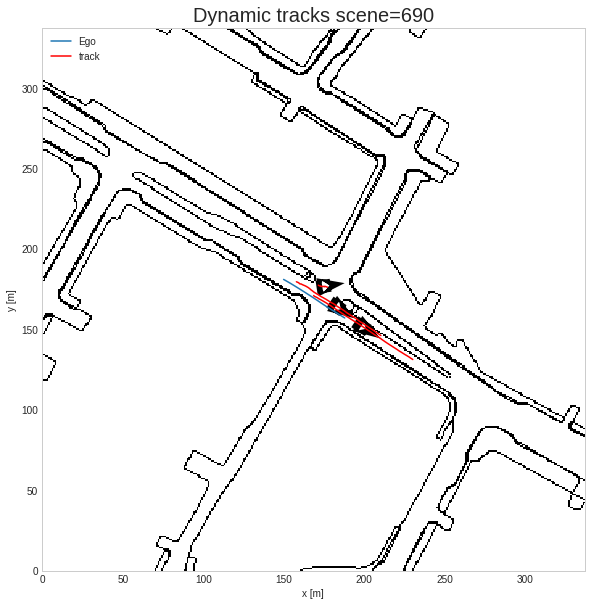

In [43]:
from map_utils import getRoadBorders, getCombinedMap
def drawMap(ax, nusc_map, ego_path):
    x_min = np.min(ego_path[:,0])
    x_max = np.max(ego_path[:,0])
    x_mean = 0.5*(x_min+x_max)
    y_min = np.min(ego_path[:,1])
    y_max = np.max(ego_path[:,1])
    y_mean = 0.5*(y_min+y_max)
    patch_size = int(max(abs(y_max-y_min), abs(x_max-x_min))) + 300

    first_pos = [x_mean, y_mean]
    patch_size = patch_size
    edges = getCombinedMap(nuscMap=nusc_map, worldRef=first_pos, patchSize=patch_size)

    ax.imshow(edges, origin='lower')
    ax.grid(False)
    #ax.set_xlim([patch_size/2 - (x_mean-x_min) - 100,patch_size/2 + (x_max-x_mean) + 100])
    #ax.set_ylim([patch_size/2 - (y_mean-y_min) - 100,patch_size/2 + (y_max-y_mean) + 100])
    
    x_offset = -first_pos[0]+patch_size*0.5
    y_offset = -first_pos[1]+patch_size*0.5
    return x_offset, y_offset

def drawTrack(ax, trk, x_offset=0, y_offset=0, velThr=2):
    if trk.confirmed:
        hstate, hego, hspeed = trk.getHistory()
        history_len = hstate.shape[0]
        if trk.hits > 10:
        #rotate translate each state according to hego
            tstate = np.zeros((hstate.shape[0], 2, 1))
            tspeed = np.zeros((hstate.shape[0], 2, 1))
            for i, (state, ego, speed) in enumerate(zip(hstate, hego, hspeed)):
                R = np.array([[np.cos(ego["heading"]), -np.sin(ego["heading"])], [np.sin(ego["heading"]), np.cos(ego["heading"])]])
                tstate[i, :, :] = np.dot(R, state[0:2]) + ego["T"][0:2].reshape(-1,1)
                tspeed[i, :, :] = np.dot(R, state[2:4]) + np.dot(R, speed[0:2].reshape(-1,1))
            abs_vel = np.mean(np.linalg.norm(tspeed,axis=1), axis=0)
            print(f"abs_vel ={abs_vel}")
            if abs_vel < velThr:
                return
            
            ax.plot(tstate[:,0]+x_offset, tstate[:,1]+y_offset, color='red',label='track')
            dx = tstate[int(history_len / 2) + 1,0]-tstate[int(history_len / 2) - 1,0]
            dy = tstate[int(history_len / 2) + 1,1]-tstate[int(history_len / 2) - 1,1]
            ax.arrow(np.mean(tstate[:,0]+x_offset), np.mean(tstate[:,1]+y_offset), dx[0], dy[0], shape='full', lw=13, length_includes_head=True, head_width=.05)

tracks = tracker.getHistory()
N = len(tracks)
print(f"Total number of tracks = {N}")

fig, ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title(f"Dynamic tracks scene={scene_id}", fontsize=20)
ax.set(xlabel='x [m]', ylabel='y [m]')
ego_path = dataset.getEgoPath()[:n_frames]
nusc_map = dataset.getMap()
x_offset, y_offset = drawMap(ax, nusc_map, ego_path)
ax.plot(ego_path[start_frame:n_frames,0]+x_offset, ego_path[start_frame:n_frames,1]+y_offset,label='Ego')
for idx,trk in enumerate(tracks):
    drawTrack(ax, trk, x_offset=x_offset, y_offset=y_offset, velThr=2)
ax.legend(loc="upper left")
    